Импортируем нужные библиотеки

In [426]:
import pandas as pd
import seaborn as sns
import ydata_profiling
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import warnings

In [427]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

Прочтем файл

In [428]:
file_path = 'Ad_revenue.xlsx'

Создадим датасеты

In [429]:
df_ad_revenue = pd.read_excel(file_path, sheet_name = 'ad revenue')

In [430]:
df_installs_data = pd.read_excel(file_path, sheet_name = 'installs data')

Взглянем на датасеты

In [431]:
df_ad_revenue.head(10)

,install_date,event_date,event_revenue,platform,user_id
0,2023-09-21,2023-09-21,0.316470,android,1695339148585-8391306266630234966
1,2023-09-21,2023-09-21,0.063103,android,1695280270975-5411644856462553821
2,2023-09-21,2023-09-21,0.316470,android,1695317488398-8939481192662600393
3,2023-09-21,2023-09-21,0.054710,android,1695317488398-8939481192662600393
4,2023-09-21,2023-09-21,0.024880,android,1695280270975-5411644856462553821
5,2023-09-21,2023-09-21,0.065016,android,1695317488398-8939481192662600393
6,2023-09-21,2023-09-21,0.000590,android,1695339967828-2936034894368767079
7,2023-09-21,2023-09-21,0.374010,android,1695317488398-8939481192662600393
8,2023-09-21,2023-09-21,0.035976,android,1695280270975-5411644856462553821
9,2023-09-21,2023-09-21,0.068990,android,1695339967828-2936034894368767079


In [432]:
df_installs_data.head(10)

,install_date,installs,platform
0,2023-09-21,1,android
1,2023-09-21,0,android
2,2023-09-21,47,android
3,2023-09-21,0,android
4,2023-09-21,0,android
5,2023-09-21,4,android
6,2023-09-21,1,android
7,2023-09-21,41,android
8,2023-09-21,11,android
9,2023-09-21,2,android


In [433]:
df_ad_revenue['install_date'] = pd.to_datetime(df_ad_revenue['install_date'])
df_ad_revenue['event_date'] = pd.to_datetime(df_ad_revenue['event_date'])

In [434]:
#ydata_profiling.ProfileReport(df_ad_revenue, explorative=True).to_widgets()

In [435]:
#ydata_profiling.ProfileReport(df_installs_data, explorative=True).to_widgets()

Сгруппируем установки по дате

In [436]:
df_installs_dates = df_installs_data.groupby('install_date')['installs'].sum().reset_index()
df_installs_dates

,install_date,installs
0,2023-09-21,718
1,2023-09-22,671
2,2023-09-23,693
3,2023-09-24,891
4,2023-09-25,1349
5,2023-09-26,1612
6,2023-09-27,1649
7,2023-09-28,1594


Сгруппируем прибыль по дате установки и посчитаем кумулятивную прибыль

In [437]:
install_date_revenue = df_ad_revenue.groupby('install_date')['event_revenue'].sum().reset_index()
install_date_revenue['cumulative_revenue'] = install_date_revenue['event_revenue'].cumsum()

In [438]:
install_date_revenue

,install_date,event_revenue,cumulative_revenue
0,2023-09-21,565.577608,565.577608
1,2023-09-22,635.464425,1201.042033
2,2023-09-23,742.279232,1943.321265
3,2023-09-24,1012.421014,2955.742279
4,2023-09-25,1458.796868,4414.539147
5,2023-09-26,1577.301640,5991.840787
6,2023-09-27,1496.667418,7488.508205
7,2023-09-28,1200.336723,8688.844928


За данный промежуток времени было заработано 8688

Построим график роста прибыли

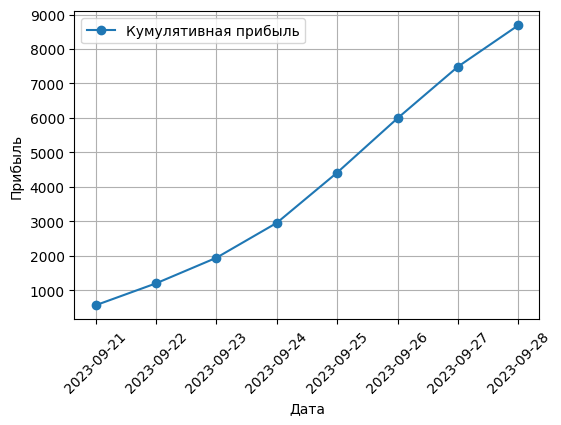

In [439]:
# Построение графика
plt.figure(figsize=(6, 4))

# График для install_date_revenue
plt.plot(install_date_revenue['install_date'], install_date_revenue['cumulative_revenue'], label='Кумулятивная прибыль', marker='o')

# Настройки графика
plt.xlabel('Дата')
plt.ylabel('Прибыль')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Показать график
plt.show()

Сгруппируем данные по дате установки и по дате совершения события, чтобы знать, сколько прибыли приносит когорта в определенный день

In [440]:
grouped_revenue = df_ad_revenue.groupby(['install_date', 'event_date']).agg({'event_revenue': 'sum'}).reset_index()
grouped_revenue['cumulative_revenue'] = grouped_revenue.groupby('install_date')['event_revenue'].cumsum()
grouped_revenue['event_date'] = pd.to_datetime(grouped_revenue['event_date']).dt.date
grouped_revenue['install_date'] = pd.to_datetime(grouped_revenue['install_date']).dt.date

Взглянем на первые строки

In [441]:
grouped_revenue.head(15)

,install_date,event_date,event_revenue,cumulative_revenue
0,2023-09-21,2023-09-21,251.841119,251.841119
1,2023-09-21,2023-09-22,90.565458,342.406577
2,2023-09-21,2023-09-23,56.141451,398.548028
3,2023-09-21,2023-09-24,41.126944,439.674972
4,2023-09-21,2023-09-25,33.507381,473.182353
5,2023-09-21,2023-09-26,24.621159,497.803512
6,2023-09-21,2023-09-27,22.338273,520.141785
7,2023-09-21,2023-09-28,15.735000,535.876785
8,2023-09-21,2023-09-29,15.875869,551.752654
9,2023-09-21,2023-09-30,13.824954,565.577608


Построим графики по кумулятивной прибыли каждой когорты и прибыли каждой когорты в определенный день

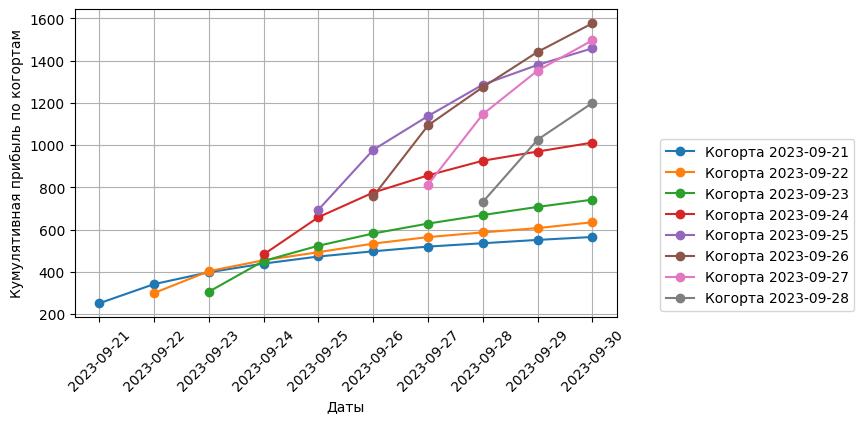

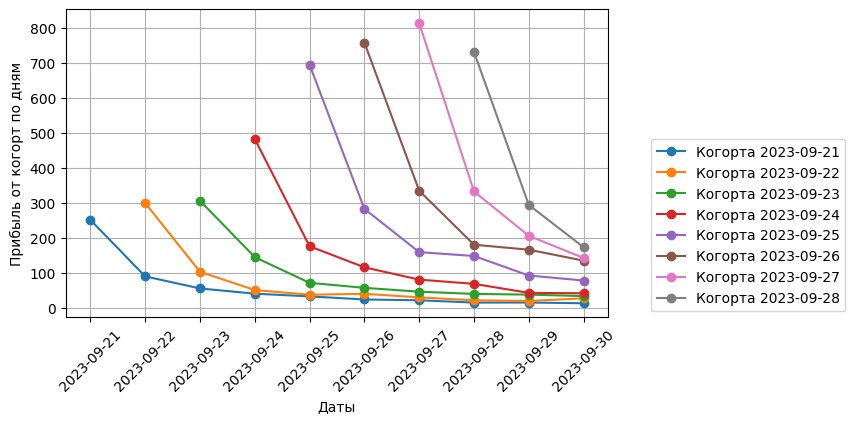

In [442]:
unique_install_dates = grouped_revenue['install_date'].unique()

plt.figure(figsize=(7, 4))

# Построение графиков для каждой когорты
for date in unique_install_dates:
    cohort_data = grouped_revenue[grouped_revenue['install_date'] == date]
    plt.plot(cohort_data['event_date'], cohort_data['cumulative_revenue'], marker='o', label=f'Когорта {date}')

plt.xlabel('Даты')
plt.ylabel('Кумулятивная прибыль по когортам')
plt.xticks(rotation=45)
plt.legend(title='Install Date')
plt.legend(loc='upper right', bbox_to_anchor=(1.45, 0.6))
plt.grid(True)

plt.figure(figsize=(7, 4))

for date in unique_install_dates:
    cohort_data = grouped_revenue[grouped_revenue['install_date'] == date]
    plt.plot(cohort_data['event_date'], cohort_data['event_revenue'], marker='o', label=f'Когорта {date}')

plt.xlabel('Даты')
plt.ylabel('Прибыль от когорт по дням')
plt.xticks(rotation=45)
plt.legend(title='Install Date')
plt.grid(True)
plt.legend(loc='upper right', bbox_to_anchor=(1.45, 0.6))
plt.show()

График показывает, что пиковые значения дохода приходятся на нулевой день и затем происходит снижение прибыли: показатели доходности бесконечно стремятся к значениям, близким к нулю.
___
Чтобы примерно узнать, к каким конкретно значениям, нужно провести определенные действия с имеющимися данными

Создадим копию данных, с которой будем проводить манипуляции и узнаем процентное изменение ревеню

In [443]:
# Создаем копию
grouped_revenue_x = grouped_revenue.copy()

# Добавляем новый столбец с процентным изменением event_revenue
grouped_revenue_x['revenue_change_percentage'] = grouped_revenue_x.groupby('install_date')['event_revenue'].pct_change() * 100

# Заполняем значения NaN в столбце revenue_change_percentage, так как у первого значения не с чем сравнивать
grouped_revenue_x['revenue_change_percentage'] = round(grouped_revenue_x['revenue_change_percentage'].fillna(0), 1)

Взглянем на результат

In [444]:
grouped_revenue_x.head(10)

,install_date,event_date,event_revenue,cumulative_revenue,revenue_change_percentage
0,2023-09-21,2023-09-21,251.841119,251.841119,0.0
1,2023-09-21,2023-09-22,90.565458,342.406577,-64.0
2,2023-09-21,2023-09-23,56.141451,398.548028,-38.0
3,2023-09-21,2023-09-24,41.126944,439.674972,-26.7
4,2023-09-21,2023-09-25,33.507381,473.182353,-18.5
5,2023-09-21,2023-09-26,24.621159,497.803512,-26.5
6,2023-09-21,2023-09-27,22.338273,520.141785,-9.3
7,2023-09-21,2023-09-28,15.735000,535.876785,-29.6
8,2023-09-21,2023-09-29,15.875869,551.752654,0.9
9,2023-09-21,2023-09-30,13.824954,565.577608,-12.9


Этим действием хочу в дальнейшем вычеслить среднее изменение прибыльности когорт
___
Выделю в отдельный столбец ревеню n-го дня для каждой из когорт

In [445]:
grouped_revenue_x['date_difference'] = grouped_revenue_x['event_date'] - grouped_revenue_x['install_date']

Построим матрицы

In [446]:
grouped_revenue_x.pivot_table(index='date_difference', values='event_revenue', columns='install_date')

install_date,2023-09-21,2023-09-22,2023-09-23,2023-09-24,2023-09-25,2023-09-26,2023-09-27,2023-09-28
date_difference,,,,,,,,
0 days,251.841119,300.111305,306.577607,482.915337,694.915775,758.604056,813.666756,731.685673
1 days,90.565458,103.674790,145.538263,176.550508,283.410680,335.289463,333.311222,294.772395
2 days,56.141451,51.588687,72.104858,116.522508,159.793374,181.071213,206.490531,173.878655
3 days,41.126944,38.160328,57.893249,81.355243,148.827189,166.798679,143.198909,NaN
4 days,33.507381,40.813402,46.839055,69.221092,93.082035,135.538229,NaN,NaN
5 days,24.621159,30.652771,40.534951,43.504135,78.767815,NaN,NaN,NaN
6 days,22.338273,22.257539,38.498643,42.352191,NaN,NaN,NaN,NaN
7 days,15.735000,20.274095,34.292606,NaN,NaN,NaN,NaN,NaN
8 days,15.875869,27.931508,NaN,NaN,NaN,NaN,NaN,NaN


In [447]:
grouped_revenue_x.pivot_table(index='date_difference', values='revenue_change_percentage', columns='install_date')

install_date,2023-09-21,2023-09-22,2023-09-23,2023-09-24,2023-09-25,2023-09-26,2023-09-27,2023-09-28
date_difference,,,,,,,,
0 days,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1 days,-64.0,-65.5,-52.5,-63.4,-59.2,-55.8,-59.0,-59.7
2 days,-38.0,-50.2,-50.5,-34.0,-43.6,-46.0,-38.0,-41.0
3 days,-26.7,-26.0,-19.7,-30.2,-6.9,-7.9,-30.7,NaN
4 days,-18.5,7.0,-19.1,-14.9,-37.5,-18.7,NaN,NaN
5 days,-26.5,-24.9,-13.5,-37.2,-15.4,NaN,NaN,NaN
6 days,-9.3,-27.4,-5.0,-2.6,NaN,NaN,NaN,NaN
7 days,-29.6,-8.9,-10.9,NaN,NaN,NaN,NaN,NaN
8 days,0.9,37.8,NaN,NaN,NaN,NaN,NaN,NaN


Теперь можно вывести средние значения

In [448]:
average_revenue_change = round(grouped_revenue_x.pivot_table(index='date_difference', values='revenue_change_percentage', columns='install_date').mean(axis=1), 1)

In [449]:
average_revenue_change

date_difference
0 days     0.0
1 days   -59.9
2 days   -42.7
3 days   -21.2
4 days   -17.0
5 days   -23.5
6 days   -11.1
7 days   -16.5
8 days    19.3
9 days   -12.9
dtype: float64

Заменим среднее для 8-го дня, ибо данное число сильно выбивается из ряда

In [450]:
modified_revenue_change_df = average_revenue_change.copy()

modified_revenue_change_df.loc[pd.Timedelta(days=8)] = -14

modified_revenue_change_df = modified_revenue_change_df.reset_index()

modified_revenue_change_df.rename(columns = {0:'revenue_change_percentage'}, inplace = True )

In [451]:
modified_revenue_change_df

,date_difference,revenue_change_percentage
0,0 days,0.0
1,1 days,-59.9
2,2 days,-42.7
3,3 days,-21.2
4,4 days,-17.0
5,5 days,-23.5
6,6 days,-11.1
7,7 days,-16.5
8,8 days,-14.0
9,9 days,-12.9


Теперь с помощью этих значений попробуем спрогнозировать ревеню каждого (до 9-го) дня для каждой когорты

In [452]:
# Проверим тип данных в столбце 'date_difference' в modified_revenue_change_df
print(modified_revenue_change_df['date_difference'].dtype)

# Если 'date_difference' уже в правильном формате, то преобразование не требуется
if modified_revenue_change_df['date_difference'].dtype == 'O':
    # Преобразуем столбец 'date_difference' в тип timedelta, если он строковый
    modified_revenue_change_df['date_difference'] = pd.to_timedelta(
        modified_revenue_change_df['date_difference'].str.replace(' days', '').astype(int), unit='d'
    )
else:
    # Если столбец уже в виде чисел, преобразуем напрямую
    modified_revenue_change_df['date_difference'] = pd.to_timedelta(
        modified_revenue_change_df['date_difference'], unit='d'
    )

# Функция для прогнозирования недостающих значений event_revenue
def forecast_missing_revenues(cohort_df, avg_revenue_change_df):
    max_known_day = cohort_df['date_difference'].max()
    last_known_revenue = cohort_df[cohort_df['date_difference'] == max_known_day]['event_revenue'].values[0]

    # Создаем список для хранения прогнозируемых значений
    predictions = []

    for day_diff in avg_revenue_change_df['date_difference']:
        if day_diff > max_known_day:
            revenue_change_percentage = avg_revenue_change_df.loc[
                avg_revenue_change_df['date_difference'] == day_diff, 
                'revenue_change_percentage'
            ].values[0]
            predicted_revenue = last_known_revenue * (1 + revenue_change_percentage / 100)
            last_known_revenue = predicted_revenue
            predictions.append({
                'install_date': cohort_df['install_date'].iloc[0],
                'date_difference': day_diff,
                'event_revenue': predicted_revenue
            })

    return pd.DataFrame(predictions)

# Применяем прогнозирование для каждой когорты
predicted_revenues = []

for install_date in grouped_revenue_x['install_date'].unique():
    cohort = grouped_revenue_x[grouped_revenue_x['install_date'] == install_date]
    predictions = forecast_missing_revenues(cohort, modified_revenue_change_df)
    predicted_revenues.append(predictions)

# Объединяем все прогнозы в один DataFrame
predicted_revenues_df = pd.concat(predicted_revenues, ignore_index=True)

# Объединяем с исходными данными
grouped_revenue_x_full = pd.concat([grouped_revenue_x, predicted_revenues_df], ignore_index=True)

# Сортируем данные по install_date и date_difference для удобства анализа
grouped_revenue_x_full = grouped_revenue_x_full.sort_values(by=['install_date', 'date_difference']).reset_index()

timedelta64[ns]


В процессе преобразований образовались пустые значения в столбцах, в частоности в `event_date` и `cumulative_revenue`. Заполним нужными нам значениями

In [453]:
# Преобразуем 'install_date' в тип datetime
grouped_revenue_x_full['install_date'] = pd.to_datetime(grouped_revenue_x_full['install_date'])

# Проверяем тип данных в 'date_difference'
print(grouped_revenue_x_full['date_difference'].dtype)

# Если 'date_difference' в строковом формате, извлекаем количество дней
if grouped_revenue_x_full['date_difference'].dtype == 'object':
    grouped_revenue_x_full['date_difference'] = grouped_revenue_x_full['date_difference'].astype(str)
    grouped_revenue_x_full['date_difference'] = grouped_revenue_x_full['date_difference'].str.extract('(\d+)').astype(float)

# Преобразуем 'date_difference' в тип timedelta
grouped_revenue_x_full['date_difference'] = pd.to_timedelta(grouped_revenue_x_full['date_difference'], unit='D')

# Обрабатываем NaN значения в 'date_difference'
grouped_revenue_x_full['date_difference'].fillna(pd.Timedelta(0), inplace=True)

# Вычисляем 'event_date'
grouped_revenue_x_full['event_date'] = grouped_revenue_x_full['install_date'] + grouped_revenue_x_full['date_difference']

# Заполняем 'cumulative_revenue'
grouped_revenue_x_full['cumulative_revenue'] = grouped_revenue_x_full['event_revenue'].cumsum()

timedelta64[ns]


In [454]:
grouped_revenue_x_full['event_date'] = pd.to_datetime(grouped_revenue_x_full['event_date']).dt.date
grouped_revenue_x_full['install_date'] = pd.to_datetime(grouped_revenue_x_full['install_date']).dt.date

Взглянем на обновленный график

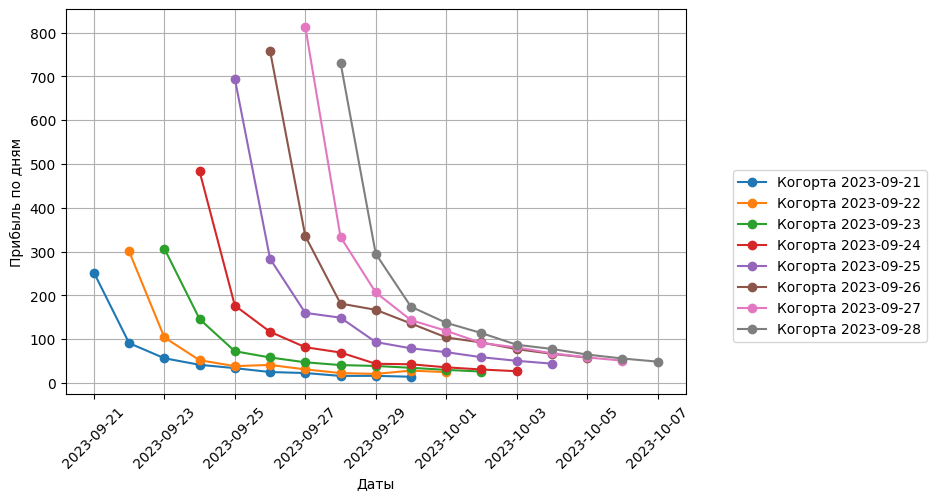

In [455]:
unique_install_dates = grouped_revenue_x_full['install_date'].unique()

plt.figure(figsize=(8, 5))

for date in unique_install_dates:
    cohort_data = grouped_revenue_x_full[grouped_revenue_x_full['install_date'] == date]
    plt.plot(cohort_data['event_date'], cohort_data['event_revenue'], marker='o', label=f'Когорта {date}')

plt.xlabel('Даты')
plt.ylabel('Прибыль по дням')
plt.xticks(rotation=45)
plt.legend(title='Install Date')
plt.grid(True)
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 0.6))
plt.show()

Посчитаем средний чек от установки для каждой когорты

In [456]:
avg_rev = grouped_revenue_x_full.groupby('install_date')['event_revenue'].sum().reset_index()

In [457]:
avg_rev['installs'] = df_installs_dates['installs']

In [458]:
avg_rev['rev_per_install'] = avg_rev['event_revenue'] / avg_rev['installs']

In [459]:
avg_rev

,install_date,event_revenue,installs,rev_per_install
0,2023-09-21,565.577608,718,0.787713
1,2023-09-22,659.792768,671,0.983298
2,2023-09-23,797.458093,693,1.150733
3,2023-09-24,1104.688019,891,1.239829
4,2023-09-25,1681.374578,1349,1.246386
5,2023-09-26,1973.980622,1612,1.224554
6,2023-09-27,1963.375057,1649,1.190646
7,2023-09-28,1783.910914,1594,1.119141


In [460]:
avg_rev['event_revenue'].sum() / avg_rev['installs'].sum()

1.147450981779908

Суммируем ревеню с 0-го по 9-й день

In [461]:
avg_rev['event_revenue'].sum()

10530.157659794215

Средняя прибыль от одной установки - 1.14
Ревеню с нулевого по девятый день - 10530

В задании есть вопросы о нарастании прибыли в первый месяц и сравнении ревеню 30-го дня. Чтобы спрогнозировать ревеню 30-го дня, используем модель прогнозирования **ARIMA**
___
Для простоты, выделим каждую когорту

In [462]:
coh_2023_09_21 = grouped_revenue_x_full[grouped_revenue_x_full['install_date'].astype(str) == "2023-09-21"].drop(columns=['revenue_change_percentage', 'date_difference'])
coh_2023_09_22 = grouped_revenue_x_full[grouped_revenue_x_full['install_date'].astype(str) == "2023-09-22"].drop(columns=['revenue_change_percentage', 'date_difference'])
coh_2023_09_23 = grouped_revenue_x_full[grouped_revenue_x_full['install_date'].astype(str) == "2023-09-23"].drop(columns=['revenue_change_percentage', 'date_difference'])
coh_2023_09_24 = grouped_revenue_x_full[grouped_revenue_x_full['install_date'].astype(str) == "2023-09-24"].drop(columns=['revenue_change_percentage', 'date_difference'])
coh_2023_09_25 = grouped_revenue_x_full[grouped_revenue_x_full['install_date'].astype(str) == "2023-09-25"].drop(columns=['revenue_change_percentage', 'date_difference'])
coh_2023_09_26 = grouped_revenue_x_full[grouped_revenue_x_full['install_date'].astype(str) == "2023-09-26"].drop(columns=['revenue_change_percentage', 'date_difference'])
coh_2023_09_27 = grouped_revenue_x_full[grouped_revenue_x_full['install_date'].astype(str) == "2023-09-27"].drop(columns=['revenue_change_percentage', 'date_difference'])
coh_2023_09_28 = grouped_revenue_x_full[grouped_revenue_x_full['install_date'].astype(str) == "2023-09-28"].drop(columns=['revenue_change_percentage', 'date_difference'])

Узнаем прогноз доходности для каждой когорты

Когорта 2023-09-21

In [463]:
# Обучение модели ARIMA
model = ARIMA(coh_2023_09_21['event_revenue'], order=(1, 1, 0))  # Параметры модели (p, d, q)
model_fit = model.fit()

# Прогноз на будущее (до 2023-10-20)
forecast_days = 21  # количество дней для прогноза
forecast_2023_09_21 = model_fit.forecast(steps=forecast_days)

# Прогнозируемые значения для когорты
forecast_2023_09_21

10    12.159622
11    10.807381
12     9.709368
13     8.817787
14     8.093828
15     7.505977
16     7.028646
17     6.641055
18     6.326333
19     6.070780
20     5.863273
21     5.694778
22     5.557961
23     5.446867
24     5.356658
25     5.283410
26     5.223932
27     5.175637
28     5.136421
29     5.104578
30     5.078722
Name: predicted_mean, dtype: float64

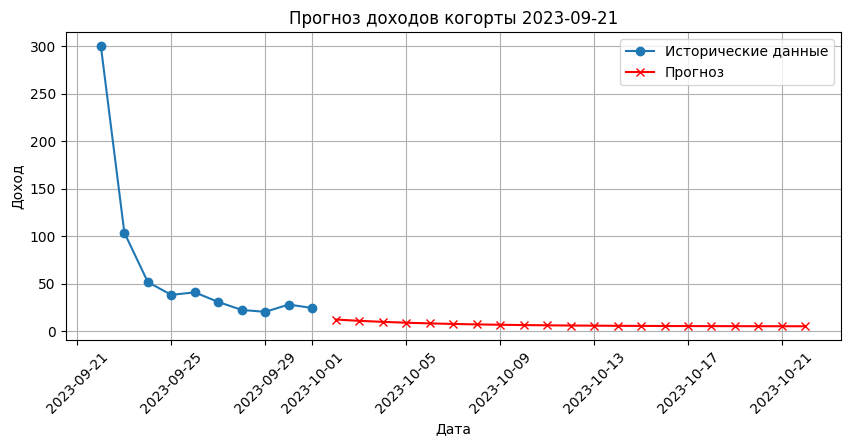

In [464]:
# Построение прогноза
forecast_dates = pd.date_range(start=coh_2023_09_22['event_date'].iloc[-1] + pd.Timedelta(days=1), periods=forecast_days, freq='D')
plt.figure(figsize=(10, 4))
plt.plot(coh_2023_09_22['event_date'], coh_2023_09_22['event_revenue'], marker='o', label='Исторические данные')
plt.plot(forecast_dates, forecast_2023_09_21, marker='x', color='red', label='Прогноз')
plt.xlabel('Дата')
plt.ylabel('Доход')
plt.title('Прогноз доходов когорты 2023-09-21')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

Примерно такой уровень прибыли в первый месяц ожидается у когорты 2023-09-21
___
Спрогнзируем доходность у остальных когорт

In [465]:
# Определяем дату для прогноза
final_date = pd.to_datetime('2023-10-19')

def pred_coh(coh):
    # Преобразуем столбец install_date в pd.Timestamp
    coh['install_date'] = pd.to_datetime(coh['install_date'])
    
    model = ARIMA(coh['event_revenue'], order=(1, 1, 0))  # Параметры модели (p, d, q)
    model_fit = model.fit()

    # Вычисляем количество дней для прогноза
    forecast_days = 21

    # Прогноз на будущее
    forecast = model_fit.forecast(steps=forecast_days)
    return forecast

In [466]:
forecast_2023_09_22 = pred_coh(coh_2023_09_22)
forecast_2023_09_23 = abs(pred_coh(coh_2023_09_23))
forecast_2023_09_24 = pred_coh(coh_2023_09_24)
forecast_2023_09_25 = pred_coh(coh_2023_09_25)
forecast_2023_09_26 = pred_coh(coh_2023_09_26)
forecast_2023_09_27 = pred_coh(coh_2023_09_27)
forecast_2023_09_28 = pred_coh(coh_2023_09_28)

In [477]:
forecast_2023_09_28

10    42.342985
11    37.265245
12    32.990488
13    29.391732
14    26.362075
15    23.811522
16    21.664307
17    19.856649
18    18.334849
19    17.053704
20    15.975156
21    15.067167
22    14.302766
23    13.659246
24    13.117490
25    12.661406
26    12.277447
27    11.954206
28    11.682081
29    11.452990
30    11.260127
Name: predicted_mean, dtype: float64

В `forecast_2023_09_23` были отрицательные значения, поэтому перевели их в положительные
___
Для интереса, суммируем прогнозируемую доходность всех когорт

In [468]:
pred_total = (
    forecast_2023_09_21.sum() + 
    forecast_2023_09_22.sum() +
    forecast_2023_09_23.sum() +
    forecast_2023_09_24.sum() +
    forecast_2023_09_25.sum() +
    forecast_2023_09_26.sum() +
    forecast_2023_09_27.sum() +
    forecast_2023_09_28.sum()
)

pred_total

2466.764310833919

Напомню, что прогнозируемая сумма ревеню 0d-9d равняется 10530, а реальная прибыль - **8688**. То есть крайние когорты доберут примерно 1842 в рамках ревеню 9d + прогнзируемые 2466 до конца месяца.

Итого, прогнозируемый доход в первый месяц жизни у пользователей игры - **4308**
___
Теперь узнаем, во сколько раз увеличится ревеню нулевого дня (день установки игры), первого и третьего дня к 30-му дню

Для этого суммируем последние значения из прогноза для каждой когорты

In [469]:
total_30d = (
    forecast_2023_09_21.iloc[-1] + 
    forecast_2023_09_22.iloc[-1] +
    forecast_2023_09_23.iloc[-1] +
    forecast_2023_09_24.iloc[-1] +
    forecast_2023_09_25.iloc[-1] +
    forecast_2023_09_26.iloc[-1] +
    forecast_2023_09_27.iloc[-1] +
    forecast_2023_09_28.iloc[-1]
)

total_30d

73.14052284486192

Теперь узнаем ревеню нулевого, первого и третьего дней

In [470]:
# Добавляем колонки, которые определяют нулевой, первый и третий дни
grouped_revenue_x_full['0d_revenue_date'] = pd.to_datetime(grouped_revenue_x_full['install_date'])
grouped_revenue_x_full['1d_revenue_date'] = pd.to_datetime(grouped_revenue_x_full['install_date']) + pd.Timedelta(days=1)
grouped_revenue_x_full['2d_revenue_date'] = pd.to_datetime(grouped_revenue_x_full['install_date']) + pd.Timedelta(days=2)
grouped_revenue_x_full['3d_revenue_date'] = pd.to_datetime(grouped_revenue_x_full['install_date']) + pd.Timedelta(days=3)

# Отфильтровываем строки, где event_date совпадает с нужным днем
zero_day_revenue = grouped_revenue_x_full[grouped_revenue_x_full['event_date'] == grouped_revenue_x_full['0d_revenue_date']]
first_day_revenue = grouped_revenue_x_full[grouped_revenue_x_full['event_date'] == grouped_revenue_x_full['1d_revenue_date']]
second_day_revenue = grouped_revenue_x_full[grouped_revenue_x_full['event_date'] == grouped_revenue_x_full['2d_revenue_date']]
third_day_revenue = grouped_revenue_x_full[grouped_revenue_x_full['event_date'] == grouped_revenue_x_full['3d_revenue_date']]

In [471]:
total_revenue_0d = zero_day_revenue['event_revenue'].sum()
total_revenue_0d

4340.317628000001

In [472]:
total_revenue_1d = first_day_revenue['event_revenue'].sum()
total_revenue_1d

1763.112779

In [473]:
total_revenue_2d = second_day_revenue['event_revenue'].sum()
total_revenue_2d

1017.591277

In [474]:
total_revenue_3d = third_day_revenue['event_revenue'].sum()
total_revenue_3d

814.3769211399999

In [475]:
print(f'Ревеню 0-го дня увеличится в {round(total_revenue_0d / total_30d)} раз по отношению к 30-му дню')
print(f'Ревеню 1-го дня увеличится в {round(total_revenue_1d / total_30d)} раза по отношению к 30-му дню')
print(f'Ревеню 3-го дня увеличится в {round(total_revenue_3d / total_30d)} раз по отношению к 30-му дню')

Ревеню 0-го дня увеличится в 59 раз по отношению к 30-му дню
Ревеню 1-го дня увеличится в 24 раза по отношению к 30-му дню
Ревеню 3-го дня увеличится в 11 раз по отношению к 30-му дню
